
## Mulitple Linear Regression
### Problem Statement
A US bike-sharing provider BoomBikes has recently suffered considerable dips in their revenues due to the ongoing Corona pandemic. The company is finding it very difficult to sustain in the current market scenario. So, it has decided to come up with a mindful business plan to be able to accelerate its revenue as soon as the ongoing lockdown comes to an end, and the economy restores to a healthy state.

They have contracted a consulting company to understand the factors on which the demand for these shared bikes depends. Specifically, they want to understand the factors affecting the demand for these shared bikes in the American market. The company wants to know:

- Which variables are significant in predicting the demand for shared bikes.
- How well those variables describe the bike demands

## Importing necessary python libraries

In [460]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import r2_score,mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Understanding bike sharing data

In [461]:
bike_data = pd.read_csv('day.csv')
bike_data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [462]:
bike_data.shape #checking the size of the data

(730, 16)

In [463]:
bike_data.info() #checking out for detailed info about the dataset
#Checking for count and the type of data present in the given dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


- data is in cleaned state, i.e no null values

## Data Cleaning

### Drop columns which are not useful for data analysis


In [464]:
#dropping instant column as it is merely a index column which has no significance for our target
bike_data.drop(['instant'],axis=1,inplace=True)


In [465]:
#dteday is not useful as month and weekday are covering it
bike_data.drop(['dteday'],axis=1,inplace=True)

# casual and registered as cnt is sum of these
bike_data.drop(['casual'],axis=1,inplace=True)
bike_data.drop(['registered'],axis=1,inplace=True)


 Inspecting data after dropping 

In [466]:
bike_data.columns #identifying all the column head

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt'],
      dtype='object')

In [467]:
bike_data.nunique() #gives info about unique values present in data

season          4
yr              2
mnth           12
holiday         2
weekday         7
workingday      2
weathersit      3
temp          498
atemp         689
hum           594
windspeed     649
cnt           695
dtype: int64

In [468]:
#changing categorical data which were primarily numeric to more meaningful one
bike_data.season.replace({1:"spring", 2:"summer", 3:"fall", 4:"winter"},inplace = True)

bike_data.weathersit.replace({1:'good',2:'moderate',3:'bad',4:'severe'},inplace = True)

bike_data.mnth = bike_data.mnth.replace({1: 'jan',2: 'feb',3: 'mar',4: 'apr',5: 'may',6: 'jun',
                  7: 'jul',8: 'aug',9: 'sept',10: 'oct',11: 'nov',12: 'dec'})

bike_data.weekday = bike_data.weekday.replace({0: 'sun',1: 'mon',2: 'tue',3: 'wed',4: 'thu',5: 'fri',6: 'sat'})
bike_data.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,0,jan,0,sat,0,moderate,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,jan,0,sun,0,moderate,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,jan,0,mon,1,good,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,jan,0,tue,1,good,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,jan,0,wed,1,good,9.305237,11.46350,43.6957,12.522300,1600


## Data analysis

### Drawing pairplots to check for linear relationship

<Figure size 1500x3000 with 0 Axes>

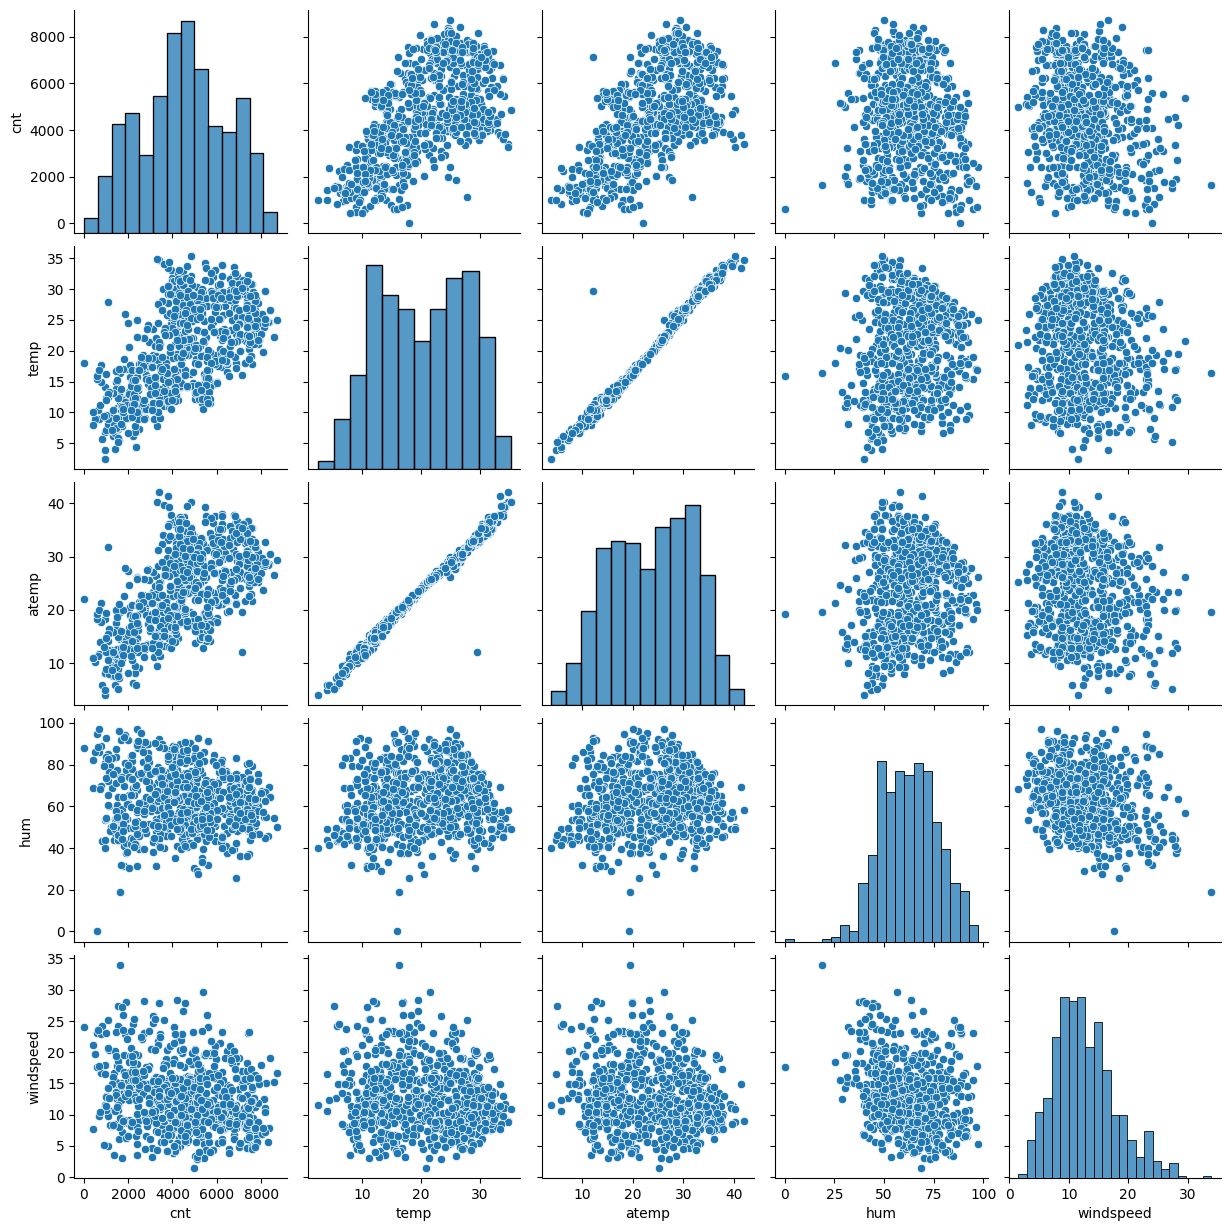

In [469]:
plt.figure(figsize = (15,30))
sns.pairplot(bike_data,vars=['cnt', 'temp', 'atemp', 'hum','windspeed'])
plt.show()

 - cnt has high coorelation with temp and atemp

### Heatmap for correlation between numeric variables

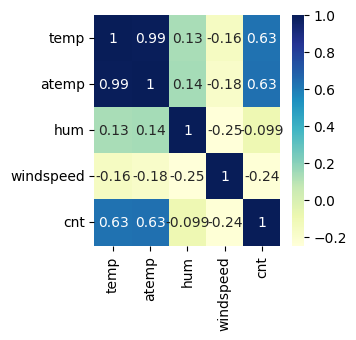

In [470]:
plt.figure(figsize=(3,3))
sns.heatmap(bike_data[['temp','atemp','hum','windspeed','cnt']].corr(),cmap="YlGnBu",annot=True)
plt.show()

<Axes: xlabel='weathersit', ylabel='cnt'>

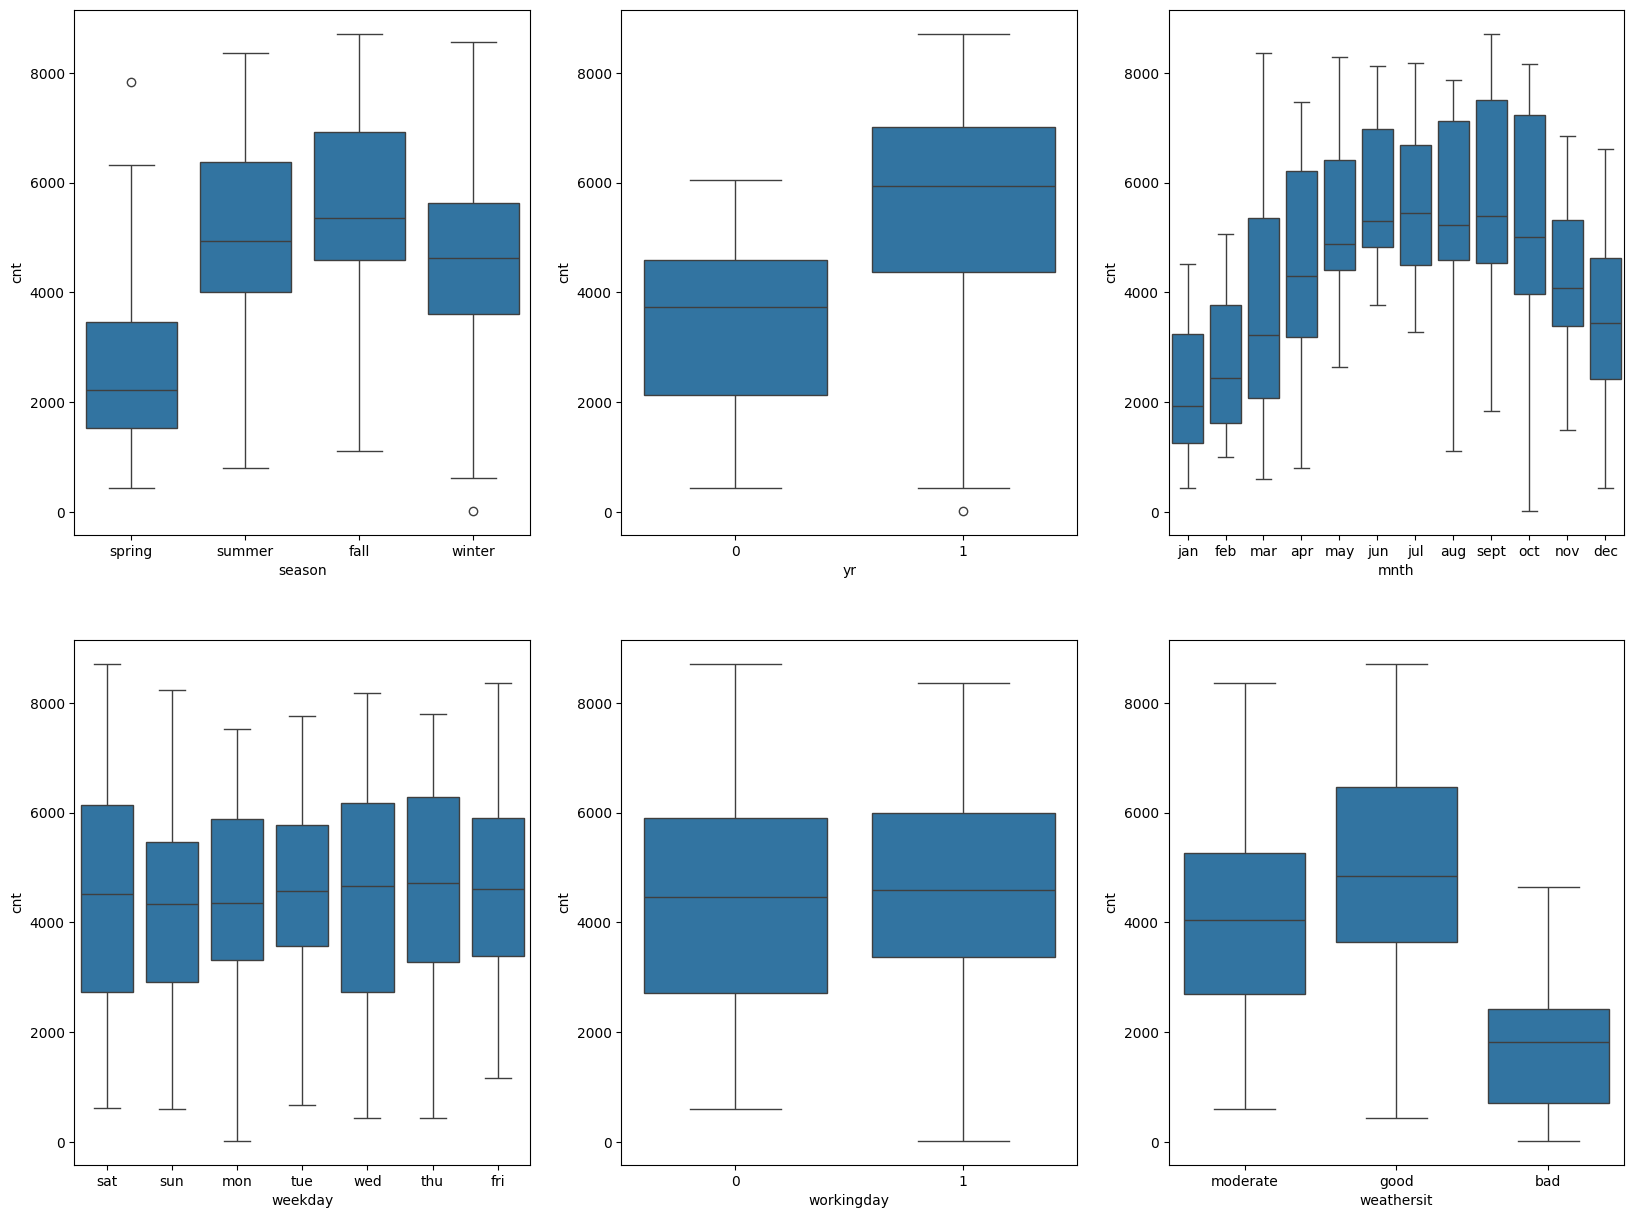

In [471]:
#visualising the categorical variables

plt.figure(figsize=(20,15))

plt.subplot(2,3,1)
sns.boxplot(x='season',y='cnt',data=bike_data)

plt.subplot(2,3,2)
sns.boxplot(x='yr',y='cnt',data=bike_data)

plt.subplot(2,3,3)
sns.boxplot(x='mnth',y='cnt',data=bike_data)

plt.subplot(2,3,4)
sns.boxplot(x='weekday',y='cnt',data=bike_data)

plt.subplot(2,3,5)
sns.boxplot(x='workingday',y='cnt',data=bike_data)

plt.subplot(2,3,6)
sns.boxplot(x='weathersit',y='cnt',data=bike_data)

## Data preparation for linear regression

Creating dummy variables for categorical variables

In [472]:
bike_data_v1 = pd.get_dummies(data=bike_data,columns=["season","mnth","weekday"],drop_first=True, dtype=int)
bike_data_v1 = pd.get_dummies(data=bike_data_v1,columns=["weathersit"], dtype=int)

In [473]:
bike_data_v1.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'cnt', 'season_spring', 'season_summer', 'season_winter', 'mnth_aug',
       'mnth_dec', 'mnth_feb', 'mnth_jan', 'mnth_jul', 'mnth_jun', 'mnth_mar',
       'mnth_may', 'mnth_nov', 'mnth_oct', 'mnth_sept', 'weekday_mon',
       'weekday_sat', 'weekday_sun', 'weekday_thu', 'weekday_tue',
       'weekday_wed', 'weathersit_bad', 'weathersit_good',
       'weathersit_moderate'],
      dtype='object')

In [474]:
bike_data_v1.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,...,mnth_sept,weekday_mon,weekday_sat,weekday_sun,weekday_thu,weekday_tue,weekday_wed,weathersit_bad,weathersit_good,weathersit_moderate
0,0,0,0,14.110847,18.18125,80.5833,10.749882,985,1,0,...,0,0,1,0,0,0,0,0,0,1
1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,1,0,...,0,0,0,1,0,0,0,0,0,1
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,...,0,1,0,0,0,0,0,0,1,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,...,0,0,0,0,0,1,0,0,1,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,...,0,0,0,0,0,0,1,0,1,0


### Splitting data into train and test data

In [475]:
#y to contain only target variable
y=bike_data_v1.pop('cnt')

#X is all remainign variable also our independent variables
X=bike_data_v1

#Train Test split with 70:30 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [476]:
X_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,season_spring,season_summer,season_winter,...,mnth_sept,weekday_mon,weekday_sat,weekday_sun,weekday_thu,weekday_tue,weekday_wed,weathersit_bad,weathersit_good,weathersit_moderate
683,1,0,1,13.188347,16.22460,62.0417,10.250129,0,0,1,...,0,0,0,0,1,0,0,0,0,1
645,1,1,0,15.716653,19.38040,70.9583,12.708493,0,0,1,...,0,1,0,0,0,0,0,0,0,1
163,0,0,1,26.035000,30.08270,49.4583,20.458450,0,1,0,...,0,1,0,0,0,0,0,0,1,0
360,0,0,1,13.325000,16.38165,76.2500,12.626150,1,0,0,...,0,0,0,0,0,1,0,0,0,1
640,1,0,1,26.957500,29.95665,79.3750,4.458569,0,0,1,...,0,0,0,0,0,0,1,0,0,1


In [477]:
# Checking shape and size for train and test
print(X_train.shape)
print(X_test.shape)
X_train

(511, 30)
(219, 30)


,yr,holiday,workingday,temp,atemp,hum,windspeed,season_spring,season_summer,season_winter,...,mnth_sept,weekday_mon,weekday_sat,weekday_sun,weekday_thu,weekday_tue,weekday_wed,weathersit_bad,weathersit_good,weathersit_moderate
683,1,0,1,13.188347,16.22460,62.0417,10.250129,0,0,1,...,0,0,0,0,1,0,0,0,0,1
645,1,1,0,15.716653,19.38040,70.9583,12.708493,0,0,1,...,0,1,0,0,0,0,0,0,0,1
163,0,0,1,26.035000,30.08270,49.4583,20.458450,0,1,0,...,0,1,0,0,0,0,0,0,1,0
360,0,0,1,13.325000,16.38165,76.2500,12.626150,1,0,0,...,0,0,0,0,0,1,0,0,0,1
640,1,0,1,26.957500,29.95665,79.3750,4.458569,0,0,1,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0,0,0,15.758268,19.00455,52.7391,18.130468,1,0,0,...,0,0,0,1,0,0,0,0,1,0
106,0,0,0,18.723347,22.28480,47.9583,20.334232,0,1,0,...,0,0,0,1,0,0,0,0,1,0
270,0,0,1,26.035000,28.75790,84.8750,9.958143,0,0,1,...,1,0,0,0,0,0,1,0,0,1
435,1,0,1,19.133347,22.97960,48.9167,13.916771,1,0,0,...,0,1,0,0,0,0,0,0,1,0


In [478]:
# Let us scale continuous variables
num_vars = ['temp','atemp','hum','windspeed']
scaler = MinMaxScaler()

#Fit and transform training set only
X_train[num_vars] = scaler.fit_transform(X_train[num_vars])

In [479]:
X_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,season_spring,season_summer,season_winter,...,mnth_sept,weekday_mon,weekday_sat,weekday_sun,weekday_thu,weekday_tue,weekday_wed,weathersit_bad,weathersit_good,weathersit_moderate
683,1,0,1,0.327133,0.322150,0.639330,0.327101,0,0,1,...,0,0,0,0,1,0,0,0,0,1
645,1,1,0,0.403972,0.404998,0.731215,0.419004,0,0,1,...,0,1,0,0,0,0,0,0,0,1
163,0,0,1,0.717562,0.685963,0.509660,0.708724,0,1,0,...,0,1,0,0,0,0,0,0,1,0
360,0,0,1,0.331287,0.326273,0.785745,0.415925,1,0,0,...,0,0,0,0,0,1,0,0,0,1
640,1,0,1,0.745598,0.682653,0.817947,0.110593,0,0,1,...,0,0,0,0,0,0,1,0,0,1


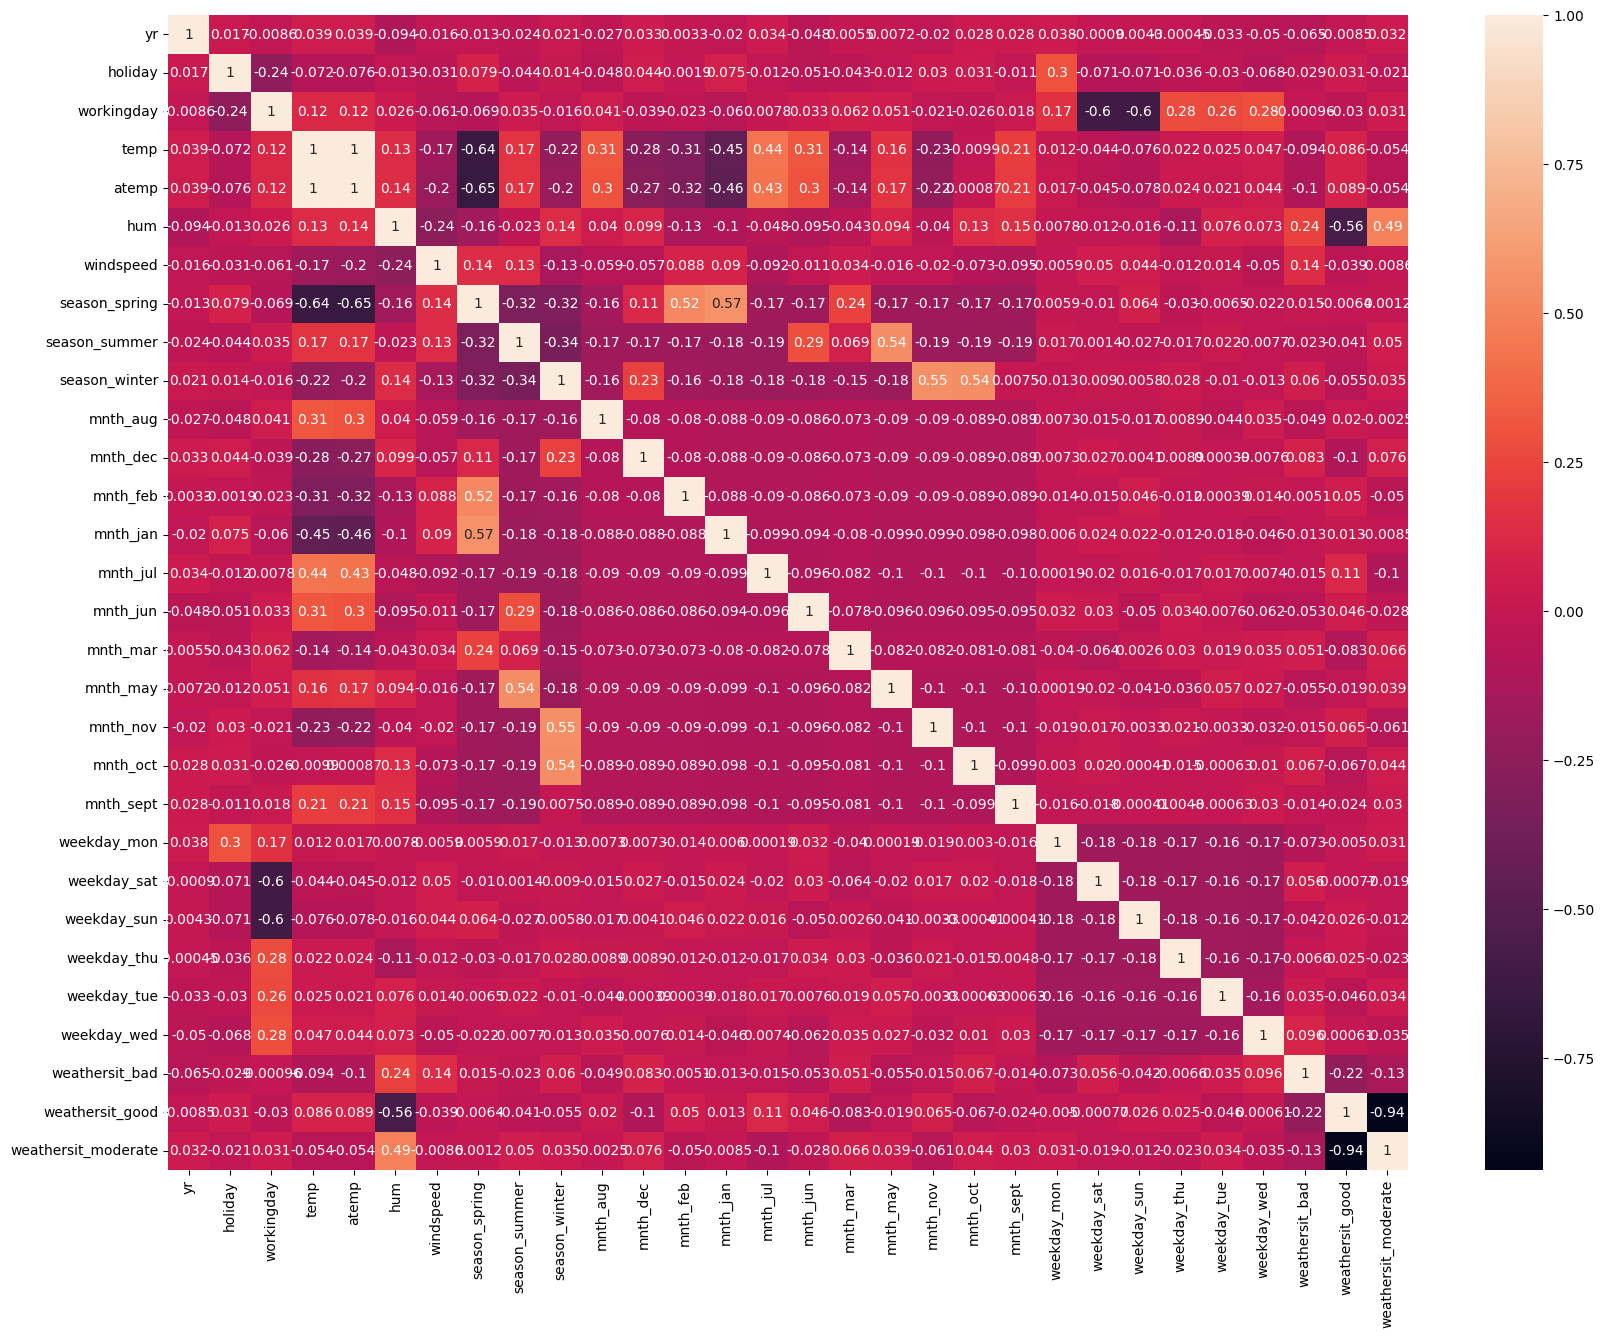

In [480]:
plt.figure(figsize = (20, 15))  #Checking if the variables are highly correlated
sns.heatmap(X_train.corr(), annot = True)
plt.show()

### Build model using RFE

In [481]:
from sklearn.feature_selection import RFE

lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [482]:
#Cut down number of features to 15 using automated approach
rfe = RFE(lr, n_features_to_select=15)
rfe.fit(X_train,y_train)

RFE(estimator=LinearRegression(), n_features_to_select=15)

In [483]:
#Columns selected by RFE and their weights
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', False, 2),
 ('workingday', True, 1),
 ('temp', False, 5),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('season_spring', True, 1),
 ('season_summer', False, 8),
 ('season_winter', True, 1),
 ('mnth_aug', False, 12),
 ('mnth_dec', True, 1),
 ('mnth_feb', False, 10),
 ('mnth_jan', False, 15),
 ('mnth_jul', True, 1),
 ('mnth_jun', False, 16),
 ('mnth_mar', True, 1),
 ('mnth_may', False, 6),
 ('mnth_nov', True, 1),
 ('mnth_oct', False, 7),
 ('mnth_sept', True, 1),
 ('weekday_mon', False, 11),
 ('weekday_sat', True, 1),
 ('weekday_sun', False, 4),
 ('weekday_thu', False, 14),
 ('weekday_tue', False, 9),
 ('weekday_wed', False, 13),
 ('weathersit_bad', True, 1),
 ('weathersit_good', True, 1),
 ('weathersit_moderate', False, 3)]

In [484]:
#Function to build a model using statsmodel api
def build_model(cols):
    X_train_sm = sm.add_constant(X_train[cols])
    lm = sm.OLS(y_train, X_train_sm).fit()
    print(lm.summary())
    return lm

In [485]:
#Function to calculate VIFs and print them -Takes the columns for which VIF to be calcualted as a parameter
def get_vif(cols):
    df1 = X_train[cols]
    vif = pd.DataFrame()
    vif['Features'] = df1.columns
    vif['VIF'] = [variance_inflation_factor(df1.values, i) for i in range(df1.shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    print(vif.sort_values(by='VIF',ascending=False))

In [486]:
#Print Columns selected by RFE. We will manually eliminate for these columns
X_train.columns[rfe.support_]


Index(['yr', 'workingday', 'atemp', 'hum', 'windspeed', 'season_spring',
       'season_winter', 'mnth_dec', 'mnth_jul', 'mnth_mar', 'mnth_nov',
       'mnth_sept', 'weekday_sat', 'weathersit_bad', 'weathersit_good'],
      dtype='object')

In [487]:
# Features not selected by RFE
X_train.columns[~rfe.support_]

Index(['holiday', 'temp', 'season_summer', 'mnth_aug', 'mnth_feb', 'mnth_jan',
       'mnth_jun', 'mnth_may', 'mnth_oct', 'weekday_mon', 'weekday_sun',
       'weekday_thu', 'weekday_tue', 'weekday_wed', 'weathersit_moderate'],
      dtype='object')

In [488]:
# Taking 15 columns supported by RFE for regression
X_train_rfe = X_train[['yr', 'workingday', 'atemp', 'hum', 'windspeed', 'season_spring',
       'season_winter', 'mnth_dec', 'mnth_jul', 'mnth_mar', 'mnth_nov',
       'mnth_sept', 'weekday_sat', 'weathersit_bad', 'weathersit_good']]

In [489]:
X_train_rfe.shape


(511, 15)

## Model-1

In [490]:
X_train_rfe.head()

,yr,workingday,atemp,hum,windspeed,season_spring,season_winter,mnth_dec,mnth_jul,mnth_mar,mnth_nov,mnth_sept,weekday_sat,weathersit_bad,weathersit_good
683,1,1,0.322150,0.639330,0.327101,0,1,0,0,0,1,0,0,0,0
645,1,0,0.404998,0.731215,0.419004,0,1,0,0,0,0,0,0,0,0
163,0,1,0.685963,0.509660,0.708724,0,0,0,0,0,0,0,0,0,1
360,0,1,0.326273,0.785745,0.415925,1,0,1,0,0,0,0,0,0,0
640,1,1,0.682653,0.817947,0.110593,0,1,0,0,0,0,0,0,0,0


In [491]:
#Selected columns for Model 1 - all columns selected by RFE
cols = ['yr', 'workingday', 'atemp', 'hum', 'windspeed', 'season_spring',
       'season_winter', 'mnth_dec', 'mnth_jul', 'mnth_mar', 'mnth_nov',
       'mnth_sept', 'weekday_sat', 'weathersit_bad', 'weathersit_good']

build_model(cols)
get_vif(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     178.2
Date:                Tue, 02 Jul 2024   Prob (F-statistic):          1.98e-188
Time:                        22:09:37   Log-Likelihood:                -4118.3
No. Observations:                 511   AIC:                             8269.
Df Residuals:                     495   BIC:                             8336.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2384.5392    345.369     

In [492]:
#Selected columns for Model 1 - all columns selected by RFE
cols = ['yr', 'atemp', 'season_spring',
       'season_winter', 'mnth_dec', 'mnth_jul', 'mnth_nov',
       'mnth_sept', 'weathersit_good']

build_model(cols)
get_vif(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     233.9
Date:                Tue, 02 Jul 2024   Prob (F-statistic):          4.35e-173
Time:                        22:09:37   Log-Likelihood:                -4171.4
No. Observations:                 511   AIC:                             8363.
Df Residuals:                     501   BIC:                             8405.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1063.0222    216.993     

### Model-2

- Here VIF seems to be almost accepted. p-value for all the features is almost 0.0 and R2 is 0.808
Hence we finalize this model to use further

In [493]:
#Build a model with all columns to select features automatically
def build_model_sk(X,y):
    lr1 = LinearRegression()
    lr1.fit(X,y)
    return lr1

In [494]:
#Let us build the finalmodel using sklearn
#Build a model with above columns
cols = ['yr', 'atemp', 'season_spring',
       'season_winter', 'mnth_dec', 'mnth_jul', 'mnth_nov',
       'mnth_sept', 'weathersit_good']

lr = build_model_sk(X_train[cols],y_train)
print(lr.intercept_,lr.coef_)

1063.0222493614615 [ 2040.39418794  4066.57273265 -1190.63374599   724.16702002
  -591.92102671  -513.39980599  -639.61746605   408.20290927
   790.60695947]


### Residual Analysis

In [495]:
y_train_pred = lr.predict(X_train[cols])

In [496]:
#Plot a histogram of the error terms
def plot_res_dist(act, pred):
    sns.distplot(act-pred)
    plt.title('Error Terms')
    plt.xlabel('Errors')

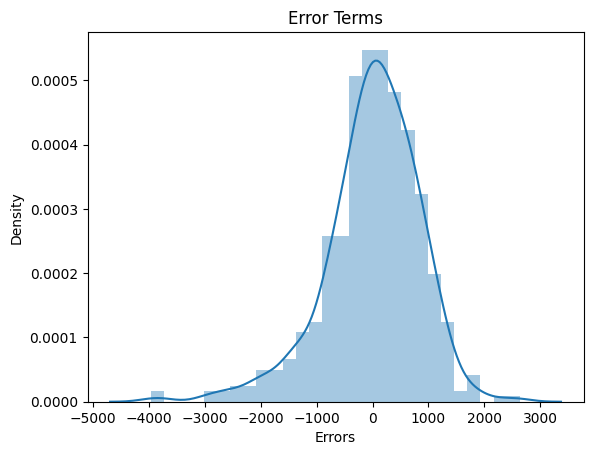

In [497]:
plot_res_dist(y_train, y_train_pred)

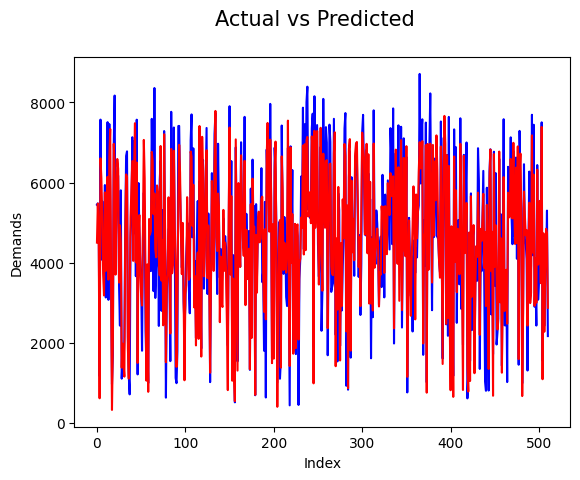

In [498]:
# Actual vs Predicted
c = [i for i in range(0,len(X_train),1)]
plt.plot(c,y_train, color="blue")
plt.plot(c,y_train_pred, color="red")
plt.suptitle('Actual vs Predicted', fontsize = 15)
plt.xlabel('Index')
plt.ylabel('Demands')
plt.show()

## Model Predictions

## R-Squared value for train predictions

In [499]:
#Print R-squared Value
r2_score(y_train,y_train_pred)

0.8077343934883947

### Prediction of values on test dataset

In [500]:
#Scale variables in X_test
num_vars = ['temp','atemp','hum','windspeed']
#Test data to be transformed only, no fitting
X_test[num_vars] = scaler.transform(X_test[num_vars])

In [501]:
X_test.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,season_spring,season_summer,season_winter,...,mnth_sept,weekday_mon,weekday_sat,weekday_sun,weekday_thu,weekday_tue,weekday_wed,weathersit_bad,weathersit_good,weathersit_moderate
468,1,0,0,0.543115,0.536771,0.518248,0.422104,0,1,0,...,0,0,1,0,0,0,0,0,1,0
148,0,0,0,0.758058,0.704203,0.843709,0.479765,0,1,0,...,0,0,0,1,0,0,0,0,1,0
302,0,0,0,0.324018,0.317998,0.642765,0.386287,0,0,1,...,0,0,0,1,0,0,0,0,1,0
355,0,0,1,0.453814,0.455552,0.780592,0.062325,1,0,0,...,0,0,0,0,1,0,0,0,0,1
515,1,0,1,0.773634,0.724915,0.507943,0.433030,0,1,0,...,0,0,0,0,1,0,0,0,1,0


In [502]:
cols = ['yr', 'atemp', 'season_spring',
       'season_winter', 'mnth_dec', 'mnth_jul', 'mnth_nov',
       'mnth_sept', 'weathersit_good']

#Predicting test data values
y_test_pred = lr.predict(X_test[cols])

## R-Squared value for test predictions

In [503]:
# Find out the R squared value between test and predicted test data sets.  
r2_score(y_test,y_test_pred)

0.7728390309987441

## Evaluating the model

In [504]:
#evaluating the model based on r2_score(as mentioned in the problem statement as well)
y_pred=y_test_pred
r2_score(y_test, y_pred)

0.7728390309987441

Text(0, 0.5, 'y_pred')

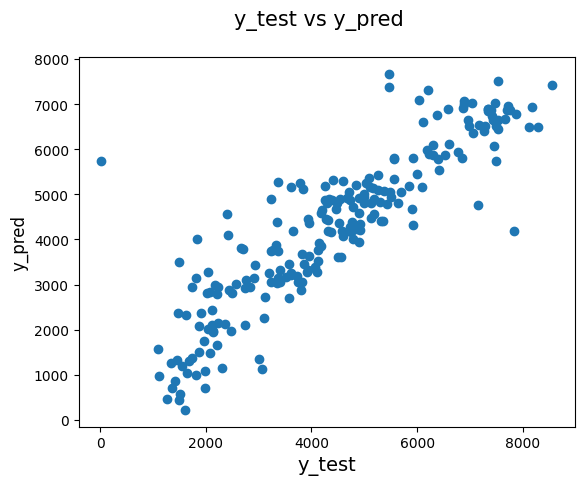

In [505]:
fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 15)             
plt.xlabel('y_test', fontsize = 14)                          
plt.ylabel('y_pred', fontsize = 12) 

In [506]:
#Let us rebuild the final model of manual + rfe approach using statsmodel to interpret it
cols_final = ['yr', 'atemp', 'season_spring',
       'season_winter', 'mnth_dec', 'mnth_jul', 'mnth_nov',
       'mnth_sept', 'weathersit_good']

lm = build_model(cols_final)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     233.9
Date:                Tue, 02 Jul 2024   Prob (F-statistic):          4.35e-173
Time:                        22:09:38   Log-Likelihood:                -4171.4
No. Observations:                 511   AIC:                             8363.
Df Residuals:                     501   BIC:                             8405.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1063.0222    216.993     

### Conclusion
Significant variables to predict the demand for shared bikes

- atemp
- season_winter
- season_spring
- months(July, September, November, December)
- Year
- Sunday
- weathersit_good